# Creating a Data Pipeline for HappyPaws

HappyPaws creates fun and educational apps for pet owners. 

HappyPaws wants to help pet owners understand their pets better by tracking their activities and health through the app. 

The data engineering team is responsible for making sure all the pet data from thousands of users is organized and safe, so pet owners can get tips to keep their pets happy and healthy.



## Task

HappyPaws has collected three datasets over the past year: 
 - "pet_activities.csv" which logs daily activities of pets, 
 - "pet_health.csv" which records vet visits and health issues, and 
 - "users.csv" which contains information about the pet owners. 

Each dataset contains unique identifiers for pets and/or their owners. 

The engineers developing the app currently write code to cross reference all of these data sources. 

They want to make things easier by having a single table with all data included.

Your manager has asked you to write a Python function that cleans and merges these datasets into a single dataset. 

The final dataset should provide a comprehensive view of each pet's activities, health records, and owner information. 

- To test your code, your manager will run only the code `all_pet_data('pet_activities.csv', 'pet_health.csv', 'users.csv')`
- Your `all_pet_data()` function must return a DataFrame, with columns as described below.
- All columns must accurately match the descriptions provided below, including names.

## Data

The data that has been provided has the following structure

![image](../assets/image.png)

The function that you write must return data as described below. There should be a unique row for each activity/health visit. 

Where missing values are permitted, they should be in the default Python format.

|Column Name | Description |
|-------|-------|
| pet_id | Unique identifier for each pet. There should not be any missing values.|
| date | The date of the activity recorded or the date of the health visit, in date format. There should not be any missing values.|
| activity_type | The type of activity, one of 'Walking', 'Playing', 'Resting' or for rows that relate to a health visit, the value 'Health'. Missing values are permitted.|
| duration_minutes | The duration of the activity in minutes. For rows that relate to health visits, this should be 0. Missing values for other activities are permitted.|
| issue | The health issue identified or check-up note. For rows that relate to activities, this should be a missing value. Missing values for health activities are permitted.|
| resolution | The outcome or advice given for the issue. For rows that relate to activities, this should be a missing value. Missing values for health activities are permitted.|
| owner_id | Unique identifier for the pet owner. All pets must have an owner.|
| owner_age_group | The age group of the owner (e.g., 18-25, 26-35, etc.). Missing values are permitted.|
| pet_type | The type of pet (e.g., Dog, Cat). Missing values are permitted.|

## Code

### Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utilities.processes import all_pet_data
from utilities.config import data, assets, code, products
import utilities.visuals as visuals

### Data preparation

In [2]:
cleaned = all_pet_data(sort=True)
cleaned.to_csv(data / 'cleaned.csv', index=False)

## Inspection and visualization

### Metadata

In [3]:
# Metadata of cleaned data
print(cleaned.dtypes)
display(cleaned.describe(include='all'))

pet_id                       int64
date                datetime64[ns]
activity_type             category
duration_minutes           float64
issue                     category
resolution                category
owner_id                     int64
owner_age_group           category
pet_type                  category
dtype: object


,pet_id,date,activity_type,duration_minutes,issue,resolution,owner_id,owner_age_group,pet_type
count,1878.000000,1878,1878,1691.000000,940,940,1878.000000,1878,1878
unique,NaN,NaN,4,NaN,4,8,NaN,6,5
top,NaN,NaN,Health,NaN,Annual Checkup,"Cleaning done, no dental issues",NaN,26-35,Fish
freq,NaN,NaN,940,NaN,479,200,NaN,350,417
mean,5159.256656,2023-02-13 17:15:54.632588032,NaN,20.086339,NaN,NaN,4915.624601,NaN,NaN
min,9.000000,2022-04-01 00:00:00,NaN,0.000000,NaN,NaN,12.000000,NaN,NaN
25%,2794.000000,2022-09-11 06:00:00,NaN,0.000000,NaN,NaN,2313.500000,NaN,NaN
50%,5288.000000,2023-02-08 00:00:00,NaN,0.000000,NaN,NaN,4945.000000,NaN,NaN
75%,7757.000000,2023-07-26 00:00:00,NaN,40.000000,NaN,NaN,7472.000000,NaN,NaN
max,9988.000000,2023-12-30 00:00:00,NaN,90.000000,NaN,NaN,9972.000000,NaN,NaN


### Distribution of pets

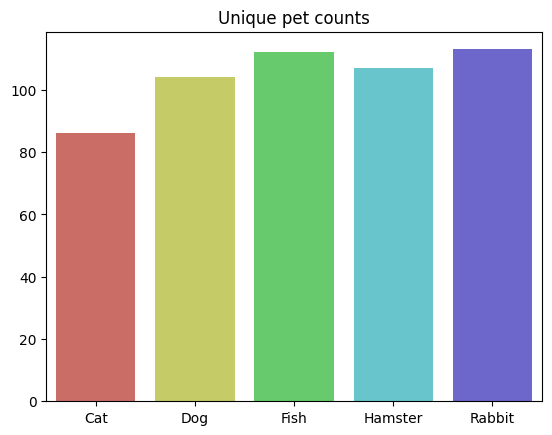

In [4]:
sns.set_palette('hls')
visuals.pet_counts(cleaned, save=True)

#### Distribution of pets by owner age groups

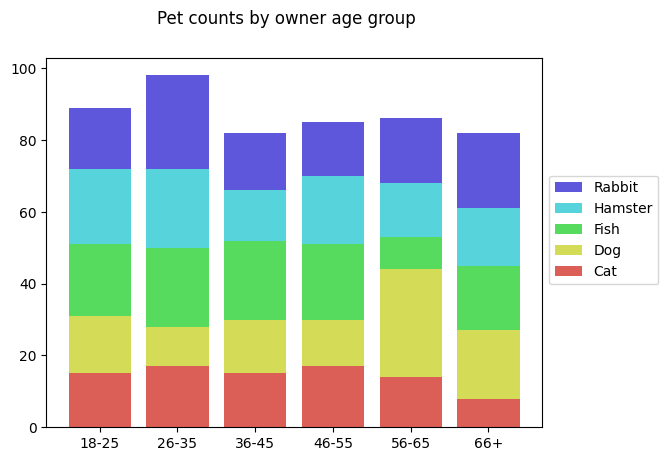

In [5]:
visuals.pet_counts_by_owner_age(data=cleaned, save=True)

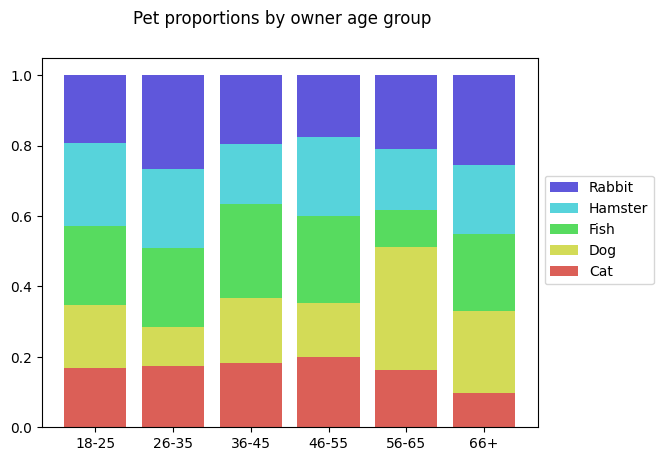

In [6]:
visuals.pet_counts_by_owner_age(data=cleaned, save=True, proportions=True)

### Distribution of health activities per month

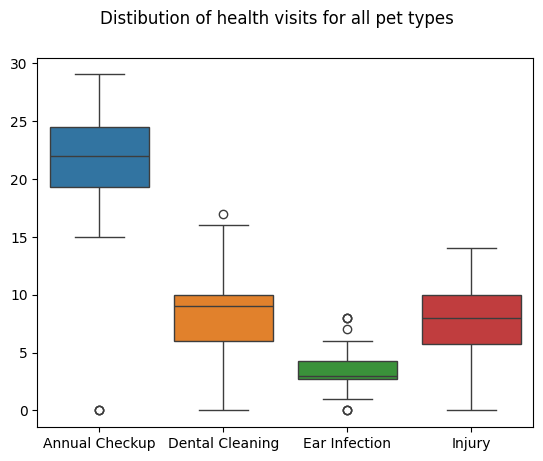

In [7]:
sns.set_palette('tab10')
visuals.health_activities_boxplots(cleaned, save=True)

#### By pet type

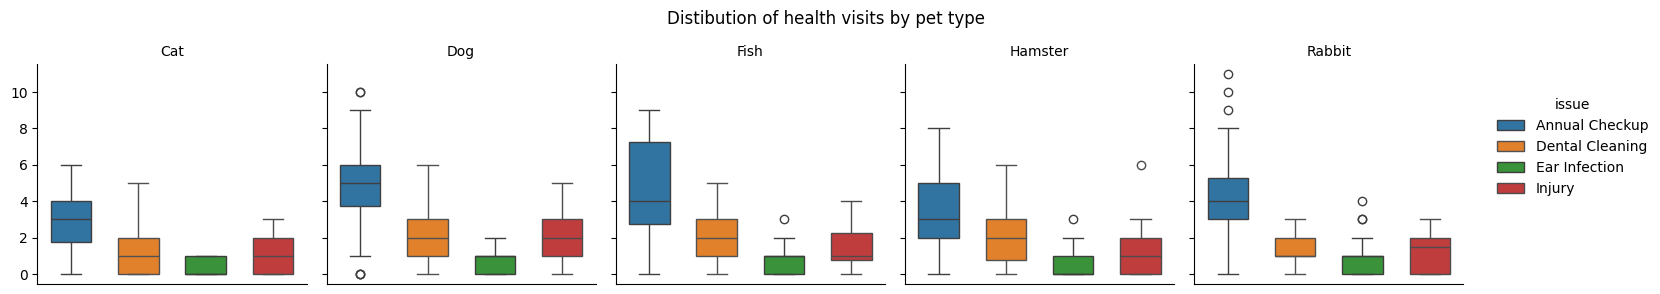

In [8]:
visuals.health_activities_boxplots(cleaned, by_type=True, save=True)


### Non-health activities

#### Counts

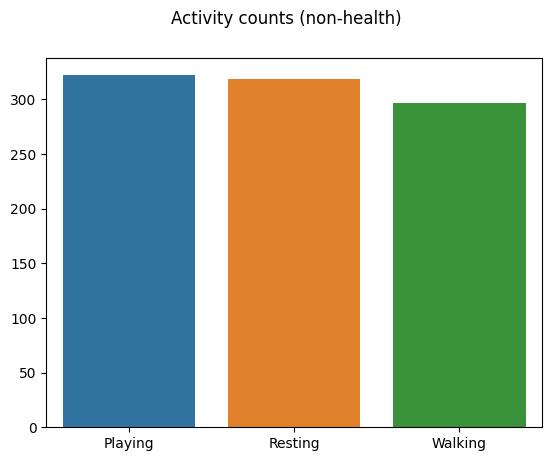

In [9]:
visuals.activities_countplots(data=cleaned, save=True)

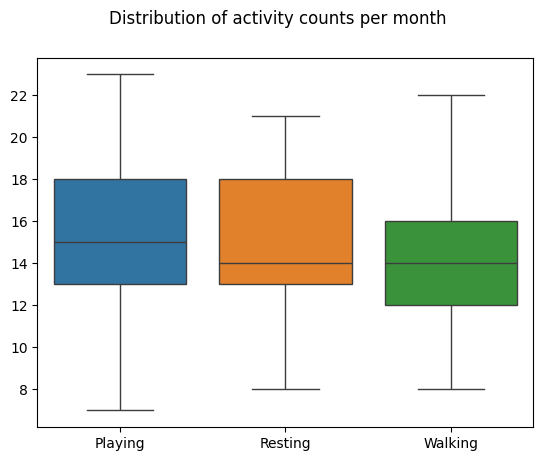

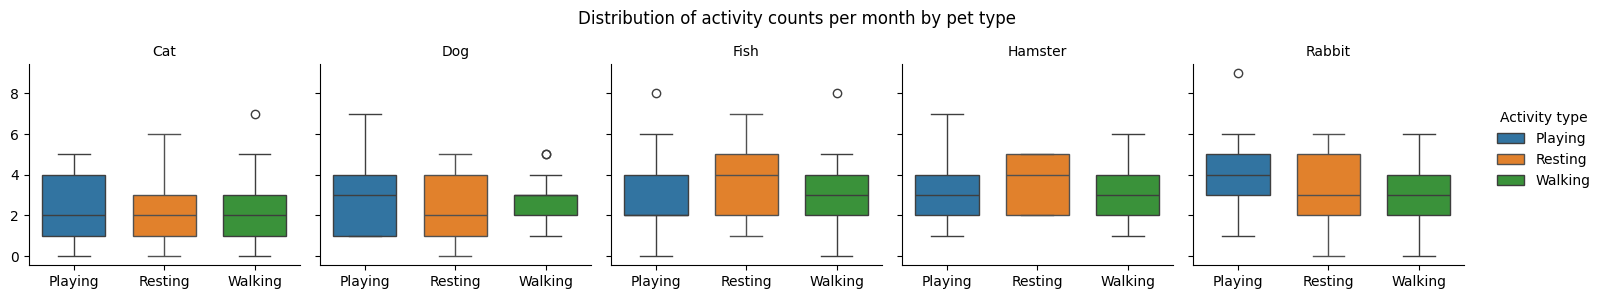

In [10]:
visuals.activities_boxplots(cleaned, save=True)

visuals.activities_boxplots(cleaned, by_type=True, save=True)

Some questions arise from this visualization:
- Why are there so many counts for "fish" and "walking"?
- 'Walking' for dogs seems low: why is that?
- What are pet owners or pets doing that counts as "playing", especially for fish, hamsters, and rabbits?

In [11]:
# Average time between check-ups (overall, by pet type, age-group)

In [12]:
# Average time between non-health records

In [13]:
# Health visits per month time series (by pet and whole group)